## Import everything and setup auto reload 

In [1]:
%reload_ext autoreload 
%autoreload 2 
%matplotlib inline 

In [2]:
import os, sys
PATH = "data/dogscats/"
print(PATH)

from fastai.imports import *
from fastai.transforms import * 
from fastai.conv_learner import * 
from fastai.dataset import * 
from fastai.sgdr import * 
from fastai.plots import * 

data/dogscats/


In [3]:
sz=224 

## Examine Cat pictures 

In [4]:
!ls {PATH}

models	sample	test1  train  valid


In [5]:
!ls {PATH}valid

cats  dogs


In [6]:
files = !ls {PATH}valid/cats | head 
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

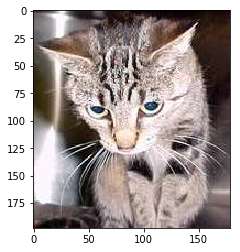

In [7]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)
img.shape
img[:4, :4]

In [8]:
img.shape

(198, 179, 3)

In [9]:
img[:4, :4]

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

# Load resnet34 architecture

In [10]:
arch=resnet34 
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn=ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:10<00:00, 8455761.71it/s] 


100%|██████████| 32/32 [00:05<00:00,  6.24it/s]


A Jupyter Widget

  9%|▉         | 33/360 [00:05<00:55,  5.89it/s, loss=0.129]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.       0.05344  0.02574  0.98926]                         
[ 1.       0.03347  0.02713  0.99023]                          
[ 2.       0.03496  0.02549  0.99023]                          



In [11]:
data.val_y 

array([0, 0, 0, ..., 1, 1, 1])

In [12]:
data.classes

['cats', 'dogs']

# Examine the training and how good it was 

In [13]:
log_preds = learn.predict()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [14]:
log_preds.shape

(2000, 2)

In [15]:
log_preds[30:40]

array([[ -0.0002 ,  -8.51819],
       [ -0.00008,  -9.47904],
       [ -0.00004, -10.05377],
       [ -0.00301,  -5.80806],
       [ -0.00011,  -9.08847],
       [ -0.     , -12.2734 ],
       [ -0.01018,  -4.59239],
       [ -0.00004, -10.13215],
       [ -0.00003, -10.46949],
       [ -0.00018,  -8.60862]], dtype=float32)

In [16]:
# Now take it to 0 or 1 all the predictions 
preds = np.argmax(log_preds, axis=1)

In [17]:
preds[30:40]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [18]:
probs=np.exp(log_preds[:,1]) # prob it is a dog. Use only the second index afterwards. 

In [19]:
probs[30:40]

array([ 0.0002 ,  0.00008,  0.00004,  0.003  ,  0.00011,  0.     ,  0.01013,  0.00004,  0.00003,  0.00018], dtype=float32)

In [20]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], 4, replace=False)

In [21]:
# is_correct is a boolean that is True or False and compares against the boolean 
# comparing the predictions with the actual values in y 
def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y) == is_correct)

In [22]:
# Plotting the value with titles 
def plot_val_with_title(idxs,title): 
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    print(imgs)
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles = title_prob) 
    

In [23]:
# Normal plot functions 
def plots(ims, figsize=(12, 6), rows=1, titles=None): 
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp= f.add_subplot(rows, len(ims) // rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])        

In [24]:
# Load img ids 
# Plot val with titles 
def load_img_id(ds, idx): 
    return np.array(PIL.Image.open(PATH + ds.fnames[idx]))


In [25]:
# Plot value with title 
def plot_val_with_title(idxs, title): 
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs=[probs[x] for x in idxs]
    print(title) 
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))


Correctly classified


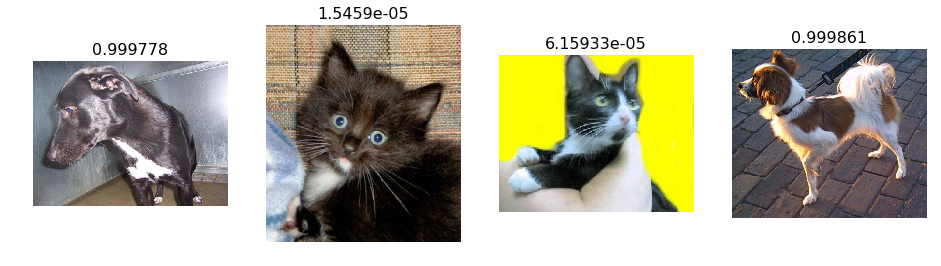

In [26]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly Classified


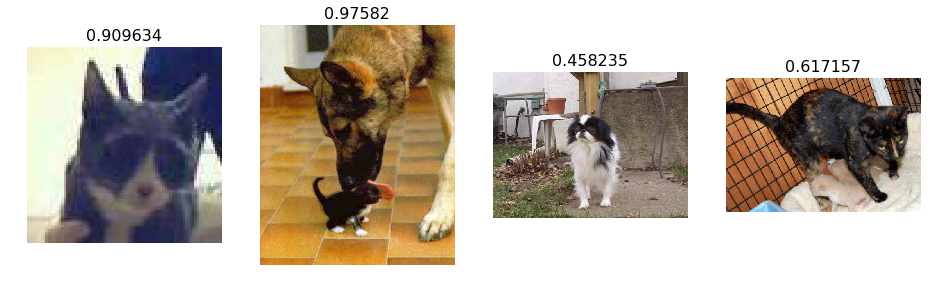

In [27]:
plot_val_with_title(rand_by_correct(False), "Incorrectly Classified")

In [28]:
def most_by_mask(mask, mult): 
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

In [29]:
def most_by_correct(y, is_correct): 
    mult=-1 if (y==1) == is_correct else 1 
    return most_by_mask((preds == data.val_y) == is_correct & (data.val_y == y ), mult)

Most correct cats 


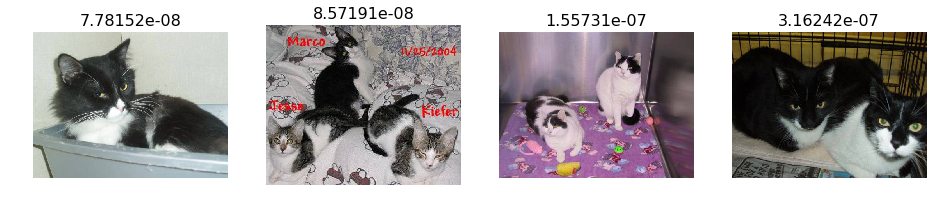

In [30]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats ")

Most correct dogs


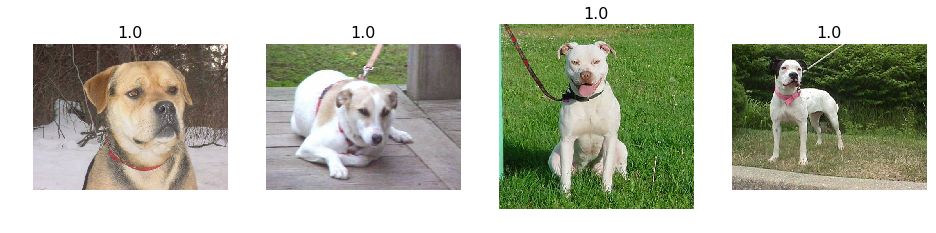

In [31]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats 


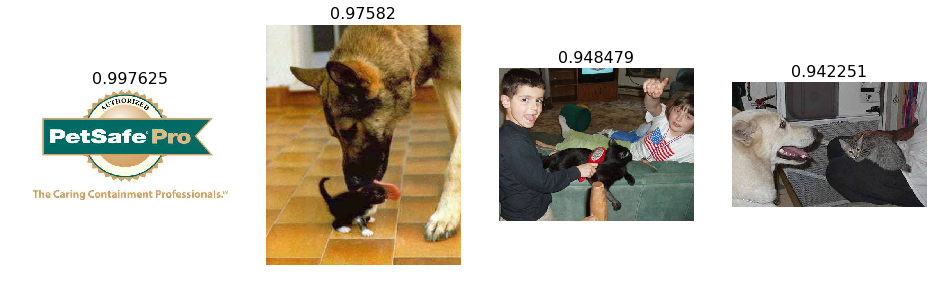

In [32]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats ")

Most incorrect dogs


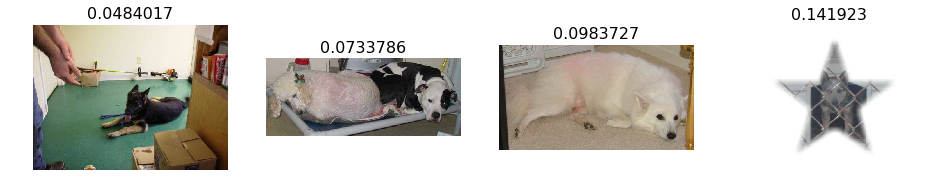

In [33]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [34]:
most_uncertain = np.argsort(np.abs(probs - 0.5 ))[:4]

Most uncertain predictions


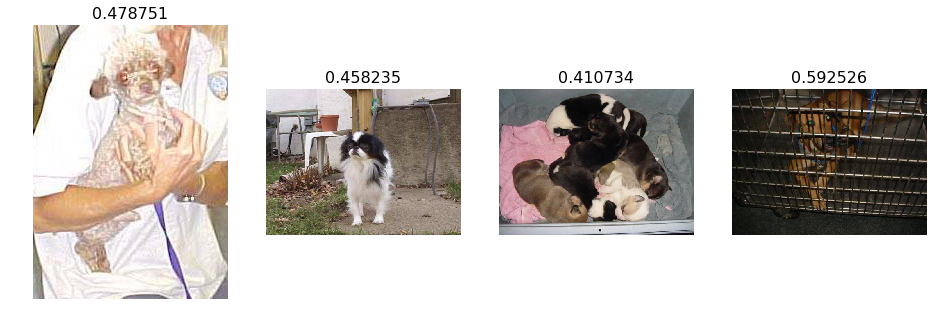

In [35]:
plot_val_with_title(most_uncertain, "Most uncertain predictions")

# Choosing a learning rate 

In [36]:
# use the learn object from before
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf = learn.lr_find()

A Jupyter Widget

  4%|▍         | 15/360 [00:00<00:13, 25.78it/s, loss=0.911]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 84%|████████▍ | 302/360 [00:01<00:00, 183.17it/s, loss=0.408] 


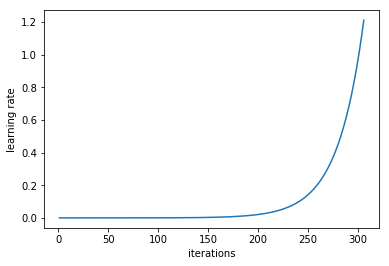

In [37]:
learn.sched.plot_lr()

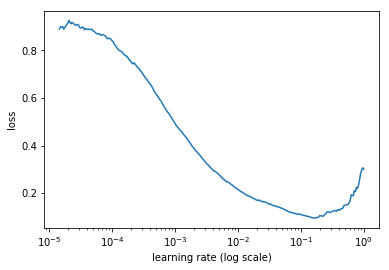

In [38]:
learn.sched.plot()

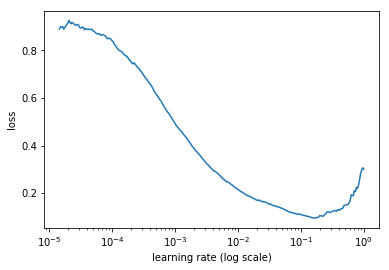

In [39]:
learn.sched.plot()

# Data augmentation 

In [40]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [43]:
def get_augs(): 
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

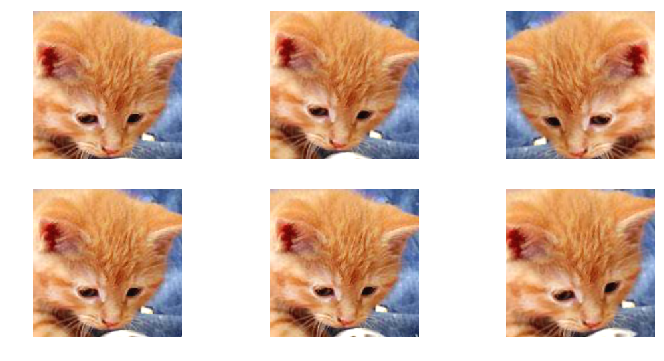

In [45]:
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

A Jupyter Widget

  4%|▍         | 15/360 [00:00<00:13, 26.40it/s, loss=0.196]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.       0.04803  0.02652  0.99121]                          



A Jupyter Widget

[ 0.       0.03402  0.02505  0.99023]                          
[ 1.       0.03809  0.02421  0.99121]                          
[ 2.       0.03596  0.02415  0.98975]                          



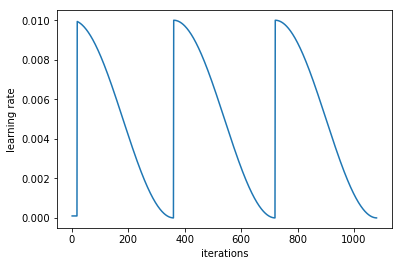

In [46]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 1)
learn.precompute=True
learn.fit(1e-2, 3, cycle_len=1)
learn.sched.plot_lr()
learn.save('224_last_layer')
learn.load('224_last_layer')

# Fine tuning and annealing 

In [48]:
learn.unfreeze()

In [50]:
lr = np.array([1e-4, 1e-3, 1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)


A Jupyter Widget

  4%|▍         | 15/360 [00:00<00:12, 27.34it/s, loss=0.0466]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.       0.02975  0.02442  0.98926]                          
[ 1.       0.02701  0.02545  0.99023]                          
[ 2.       0.03141  0.02474  0.98926]                          
[ 3.       0.03242  0.02471  0.98877]                          
[ 4.       0.03181  0.02474  0.98926]                          
[ 5.       0.03335  0.02465  0.98926]                          
[ 6.       0.03256  0.02403  0.98975]                          



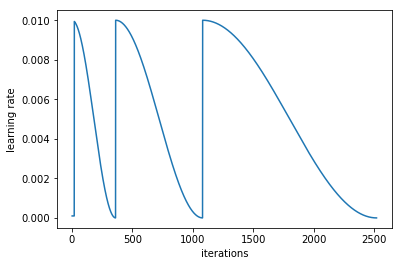

In [51]:
learn.sched.plot_lr()

In [52]:
learn.save("224_all")
learn.load("224_all")

In [53]:
log_preds, y = learn.TTA()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [54]:
accuracy(log_preds,y)

0.98950000000000005

# Analyze Results using Confusion Matrix 